<a href="https://colab.research.google.com/github/AstroBoy1/santander/blob/master/xgboost_santander.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import, setup drive, read the data

In [1]:
from google.colab import drive
from keras.models import Sequential
from keras.layers import Dense
from sklearn.metrics import roc_auc_score
import numpy as np
from sklearn import svm
from collections import Counter
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

Using TensorFlow backend.


In [2]:
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
train_fn = '/content/gdrive/My Drive/santander_data/train.csv'
valid_fn = '/content/gdrive/My Drive/santander_data/test.csv'
pred_fn = '/content/gdrive/My Drive/santander_data/submission2.csv'

In [0]:
train_data_df = pd.read_csv(train_fn)
valid_data_df = pd.read_csv(valid_fn)
train_data_x = train_data_df.drop(columns=["ID_code", "target"]).values
train_data_y = train_data_df["target"].values
valid_data_x = valid_data_df.drop(columns=["ID_code"]).values
length = len(train_data_y)

#Data preprocessing

Check for missing values, which there are none

In [5]:
null_values = train_data_df.isnull().sum()
sum(null_values > 0)

0

Check the datatypes of the features, there are 200, all are float64

In [6]:
types = train_data_df.dtypes
sum(types == 'float64')

200

Scale the data between 0 and 1

In [9]:
scalerScaled = MinMaxScaler(feature_range=(0, 1))
scaled_x = scalerScaled.fit_transform(train_data_x)
scaled_x

array([[0.42785307, 0.32482435, 0.56805853, ..., 0.43095798, 0.32765751,
        0.56064496],
       [0.55721218, 0.42863943, 0.6812351 , ..., 0.4682771 , 0.6095461 ,
        0.60582746],
       [0.41196889, 0.48377668, 0.57806091, ..., 0.38194973, 0.42583343,
        0.58273586],
       ...,
       [0.5432771 , 0.39305749, 0.4870996 , ..., 0.45612437, 0.38087342,
        0.63919915],
       [0.46750324, 0.25309006, 0.66682332, ..., 0.67445942, 0.46661746,
        0.37047369],
       [0.5258457 , 0.36714503, 0.580254  , ..., 0.36840624, 0.29469964,
        0.57890533]])

Standardize the data to a standard normal gaussian distribution, assuming originally normal data

In [10]:
scalerStandard = StandardScaler().fit(train_data_x) 
standard_x = scalerStandard.transform(train_data_x) 
standard_x

array([[-0.57710174, -1.27373702,  0.45170728, ..., -0.37396811,
        -1.02639785,  0.21413482],
       [ 0.26995857, -0.62213756,  1.19036045, ..., -0.12939961,
         0.82541712,  0.50568523],
       [-0.68111341, -0.2760664 ,  0.51698836, ..., -0.69514059,
        -0.38144932,  0.35668144],
       ...,
       [ 0.17870987, -0.84546901, -0.07667568, ..., -0.20904171,
        -0.67680579,  0.72102365],
       [-0.31746727, -1.72398014,  1.09630117, ...,  1.22180338,
        -0.11352617, -1.01298853],
       [ 0.06456676, -1.00810962,  0.53130173, ..., -0.78389704,
        -1.24290845,  0.33196403]])

# Plotting

/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


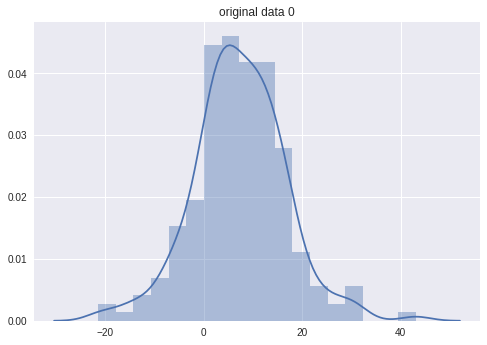

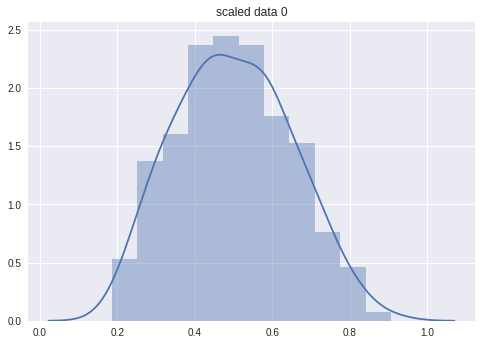

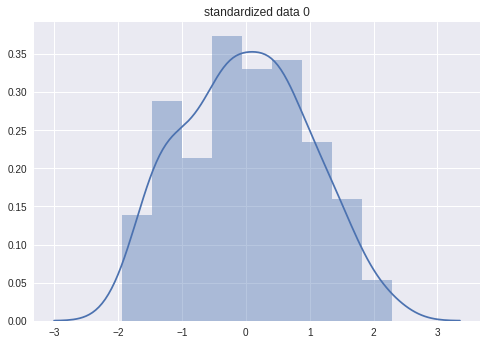

In [11]:
for i in range(0, 1):
  sns.distplot(train_data_x[i])
  plt.title("original data " + str(i))
  plt.figure()
  sns.distplot(scaled_x[i])
  plt.title("scaled data " + str(i))
  plt.figure()
  sns.distplot(standard_x[i])
  plt.title("standardized data " + str(i))

/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


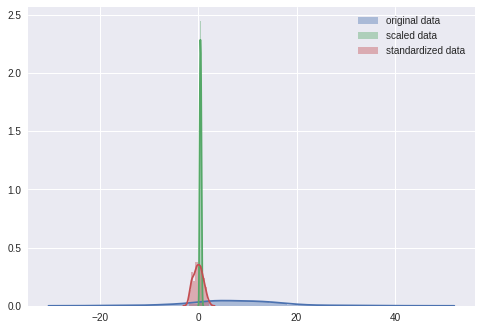

In [12]:
for i in range(0, 1):
  sns.distplot(train_data_x[i], label="original data")
  sns.distplot(scaled_x[i], label="scaled data")
  sns.distplot(standard_x[i], label="standardized data")
  plt.legend()

# Fit the data

In [0]:
# clf = svm.SVC(gamma='scale')
# print("Fitting data")
# clf.fit(train_data_x[:length], train_data_y[:length])
# print("Predicting data")
# valid_pred = clf.predict(valid_data_x[:length])

Fitting data
Predicting data


SVM

In [0]:
output_df = pd.DataFrame()
output_df["ID_code"] = valid_data_df["ID_code"]
output_df["target"] = valid_pred
output_df.to_csv(pred_fn, index=False)

In [0]:
# Started around 10:30, finished 8pm

2019-02-23 05:48:31.692752


In [0]:
from joblib import dump, load
model_fn = '/content/gdrive/My Drive/santander_data/model.joblib'
dump(clf, model_fn)

['/content/gdrive/My Drive/santander_data/model.joblib']

In [0]:
clf2 = load(model_fn)

# XGBoost

In [0]:
length = len(train_data_x)
dtrain = xgb.DMatrix(train_data_x[:length], label=train_data_y[:length])

In [0]:
# specify parameters via map
param = {'max_depth':2, 'eta':1, 'silent':1, 'objective':'binary:logistic' }
param['nthread'] = 4
param['eval_metric'] = 'auc'
num_round = 10

In [41]:
import time
start = time.time()
bst = xgb.train(param, dtrain, num_round)
bst.save_model('/content/gdrive/My Drive/santander_data/naive_xg.model')
end = time.time()
print(end - start)

16.268314599990845


In [42]:
# make prediction
start = time.time()
dtest = xgb.DMatrix(valid_data_x[:length])
preds = bst.predict(dtest)
output_df = pd.DataFrame()
output_df["ID_code"] = valid_data_df["ID_code"]
output_df["target"] = preds
output_df.to_csv(pred_fn, index=False)
end = time.time()
print(end - start)
len(preds)

1.2572906017303467


200000

In [0]:
#bst = xgb.Booster({'nthread': 4})  # init model
#bst.load_model('model.bin')  # load data

Tune XGBoost